## Bayesian methods of hyperparameter optimization

In addition to the random search and the grid search methods for selecting optimal hyperparameters, we can use Bayesian methods of probabilities to select the optimal hyperparameters for an algorithm.

In this case study, we will be using the BayesianOptimization library to perform hyperparmater tuning. This library has very good documentation which you can find here: https://github.com/fmfn/BayesianOptimization

In [1]:
#pip install bayesian-optimization

In [2]:
#pip install lightgbm

In [3]:
#pip install catboost

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool
import matplotlib.pyplot as plt

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'Bayesian_optimization_case_study.ipynb',
 'data',
 'flight_delays_test.csv.zip',
 'flight_delays_train.csv.zip']

## How does Bayesian optimization work?

Bayesian optimization works by constructing a posterior distribution of functions (Gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

<img src="https://github.com/fmfn/BayesianOptimization/blob/master/examples/bo_example.png?raw=true" />
As you iterate over and over, the algorithm balances its needs of exploration and exploitation while taking into account what it knows about the target function. At each step, a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with an exploration strategy (such as UCB — aka Upper Confidence Bound), or EI (Expected Improvement). This process is used to determine the next point that should be explored (see the gif below).
<img src="https://github.com/fmfn/BayesianOptimization/raw/master/examples/bayesian_optimization.gif" />

## Let's look at a simple example

The first step is to create an optimizer. It uses two items:
* function to optimize
* bounds of parameters

The function is the procedure that counts metrics of our model quality. The important thing is that our optimization will maximize the value on function. Smaller metrics are best. Hint: don't forget to use negative metric values.

Here we define our simple function we want to optimize.

In [3]:
def simple_func(a, b):
    return a + b

Now, we define our bounds of the parameters to optimize, within the Bayesian optimizer.

In [4]:
optimizer = BayesianOptimization(
    simple_func,
    {'a': (1, 3),
    'b': (4, 7)})

These are the main parameters of this function:

* **n_iter:** This is how many steps of Bayesian optimization you want to perform. The more steps, the more likely you are to find a good maximum.

* **init_points:** This is how many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

Let's run an example where we use the optimizer to find the best values to maximize the target value for a and b given the inputs of 3 and 2.

In [5]:
optimizer.maximize(3,2)

|   iter    |  target   |     a     |     b     |
-------------------------------------------------
|  1        |  7.013    |  2.453    |  4.559    |
|  2        |  9.107    |  2.49     |  6.617    |
|  3        |  5.604    |  1.103    |  4.501    |
|  4        |  8.845    |  1.845    |  7.0      |
|  5        |  10.0     |  3.0      |  7.0      |


Great, now let's print the best parameters and the associated maximized target.

In [6]:
print(optimizer.max['params']);optimizer.max['target']

{'a': 3.0, 'b': 7.0}


10.0

## Test it on real data using the Light GBM

The dataset I will be working with is the famous flight departures dataset. My modeling goal will be to predict if a flight departure is going to be delayed by 15 minutes based on the other attributes in our dataset. I will use Bayesian hyperparameter optimization to identify the best parameters for our model.

**<font color='teal'> You can load the zipped csv files just as you would regular csv files using Pandas read_csv. In the next cell load the train and test data into two seperate dataframes. </font>**


In [7]:
train_df = pd.read_csv('flight_delays_train.csv.zip')
test_df = pd.read_csv('flight_delays_test.csv.zip')

**<font color='teal'> Print the top five rows of the train dataframe and review the columns in the data. </font>**

In [8]:
print(train_df.shape)
train_df.head()

(100000, 9)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


**<font color='teal'> Use the describe function to review the numeric columns in the train dataframe. </font>**

In [10]:
train_df.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


Notice, `DepTime` is the departure time in a numeric representation in 2400 hours. 

In [12]:
train_df = train_df[train_df.DepTime <= 2400].copy()

 **<font color='teal'>The response variable is 'dep_delayed_15min' which is a categorical column, so we need to map the Y for yes and N for no values to 1 and 0. Run the code in the next cell to do this.</font>**

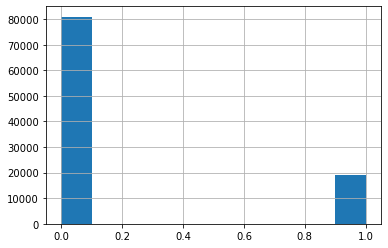

In [13]:
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})
y_train.hist()
plt.show()

**Train set is imbalanced.**

In [15]:
#Turn the Series into an array
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

## Feature Engineering
Use these defined functions to create additional features for the model. Run the cell to add the functions to your workspace.

In [16]:
def label_enc(df_column):
    df_column = LabelEncoder().fit_transform(df_column)
    return df_column

def make_harmonic_features_sin(value, period=2400):
    value *= 2 * np.pi / period 
    return np.sin(value)

def make_harmonic_features_cos(value, period=2400):
    value *= 2 * np.pi / period 
    return np.cos(value)


In [17]:
def feature_eng (df):
    #Define flight path
    df['flight'] = df['Origin']+ df['Dest']
    
    #Determine in which season flight happened
    df['Month'] = df.Month.map(lambda x: x.split('-')[-1]).astype('int32')
    df['winter'] = df['Month'].map(lambda x: x in [12, 1, 2]).astype('int32')
    df['spring'] = df['Month'].map(lambda x: x in [3, 4, 5]).astype('int32')
    df['summer'] = df['Month'].map(lambda x: x in [6, 7, 8]).astype('int32')
    df['autumn'] = df['Month'].map(lambda x: x in [9, 10, 11]).astype('int32')
    
    
    #Determine when the flight happened 
    df['DayofMonth'] = df.DayofMonth.map(lambda x: x.split('-')[-1]).astype('uint8')
    df['begin_of_month'] = (df.DayofMonth < 10).astype('uint8')
    df['middle_of_month'] = ((df.DayofMonth >= 10) & (df.DayofMonth < 20)).astype('uint8')
    df['end_of_month'] = (df.DayofMonth >= 20).astype('uint8')
    
    #Determine flight was on weakdays or holiday
    df['DayOfWeek'] = df['DayOfWeek'].map(lambda x: x.split('-')[-1]).astype('uint8')
    df['weekday'] = (df['DayOfWeek'] <= 5).astype(int)
    df['holiday'] = (df['DayOfWeek'] > 5).astype(int)
    
    #Determine flight was in the morining,day, evening or night
    df['hour'] = df.DepTime.map(lambda x: x/100).astype('int32')
    df['morning'] = df['hour'].map(lambda x: 1 if (x >= 7) & (x <= 11) else 0).astype('uint8')
    df['day'] = df['hour'].map(lambda x: 1 if (x >= 12) & (x <=18) else 0).astype('uint8')
    df['evening'] = df['hour'].map(lambda x: 1 if (x >= 19) & (x <= 23) else 0).astype('uint8')
    df['night'] = df['hour'].map(lambda x: 1 if (x >= 0) & (x <= 6) else 0).astype('uint8')
    
    #Count number of times each airport has been Origin and Destination 
    df['airport_origin_count'] = df.groupby(['Origin'])['Origin'].transform('count')
    df['airport_dest_count'] = df.groupby(['Dest'])['Dest'].transform('count')
    
    #Count number of times each airport has been Origin and Destination per month
    df['airport_origin_per_month'] = df.groupby(['Origin', 'Month'])['Origin'].transform('count')
    df['airport_des_per_month'] = df.groupby(['Dest','Month'])['Dest'].transform('count')
    
    #Count number of Destination per Unique Carrier
    df['carrier_count'] = df.groupby(['UniqueCarrier'])['Dest'].transform('count')
    
    #Count the number of Destination per Unique Carrier in each month
    df['carrier_count_per_month'] = df.groupby(['UniqueCarrier', 'Month'])['Dest'].transform('count')
    
    #
    df['DepTime_cos'] = df['DepTime'].map(make_harmonic_features_cos)
    df['DepTime_sin'] = df['DepTime'].map(make_harmonic_features_sin)
    
    #Determine each flight path used which of unique carrier
    df['flightUC'] = df['flight'] + df['UniqueCarrier']
    
    #Determine which Unique Carriers entered into each of Destinations
    df['DestUC'] = df['Dest'] + df['UniqueCarrier']
    
    #Determine which Uniqure Carriers left each of Origins
    df['OriginUC'] = df['Origin'] + df['UniqueCarrier']
    
    return df.drop('DepTime', axis=1)

Concatenate the training and testing dataframes, then apply feature engineering.


In [18]:
full_df = pd.concat([train_df.drop('dep_delayed_15min', axis=1), test_df])

#Apply the earlier defined feature engineering functions to the full dataframe.
full_df = feature_eng(full_df)

In [19]:
#Encode the categorical features
for col in ['UniqueCarrier', 'Origin', 'Dest','flight',  'flightUC', 'DestUC', 'OriginUC']:
    full_df[col] = label_enc(full_df[col])

In [20]:
print(full_df.shape)
full_df.head().T

(199983, 33)


,0,1,2,3,4
Month,8.000000,4.000000,9.000000,11.000000,10.000000
DayofMonth,21.000000,20.000000,2.000000,25.000000,7.000000
DayOfWeek,7.000000,3.000000,5.000000,6.000000,6.000000
UniqueCarrier,1.000000,19.000000,21.000000,16.000000,20.000000
Origin,19.000000,226.000000,239.000000,81.000000,182.000000
Dest,82.000000,180.000000,62.000000,184.000000,210.000000
Distance,732.000000,834.000000,416.000000,872.000000,423.000000
flight,171.000000,3986.000000,4091.000000,1304.000000,2979.000000
winter,0.000000,0.000000,0.000000,0.000000,0.000000
spring,0.000000,1.000000,0.000000,0.000000,0.000000



Split the new full dataframe into X_train and X_test. 

In [21]:
X_train = full_df[:train_df.shape[0]]
X_test = full_df[train_df.shape[0]:]

## 2 .Build a light GBM model to test the bayesian optimizer.

### [LightGBM](https://lightgbm.readthedocs.io/en/latest/) is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Create a list of the categorical features.

In [22]:
#Create a list of categorical features while their values are numeric
categorical_features = ['Month',  'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest','flight',  'flightUC', 'DestUC', 'OriginUC']

**Define the function I want to maximize and that will count cross-validation metrics of lightGBM for the hyperparameters.**

Some params such as num_leaves, max_depth, min_child_samples, min_data_in_leaf should be integers.

In [25]:
def lgb_eval(num_leaves, max_depth, lambda_l2 , lambda_l1, min_child_samples, min_data_in_leaf):
    
    #set the params
    params = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': True,    #Train set is imbalanced
              'num_leaves': int(num_leaves),
              'max_depth': int(max_depth),
              'lambdal2': lambda_l2,   #L2 regularization
              'lambda_l1' :lambda_l1,  #L1 regularization
              'num_thread': 20,        #set this to the number of real CPU cores
              'min_child_samples': int(min_child_samples),
              'min_data_in_leaf': int(min_data_in_leaf),
              'learning_rate' : 0.03,
              'subsample_freq' : 5,    #frequency for bagging; perform bagging at every 5 iteration
              'bagging_seed': 42,
              'verbosity': -1          #controls the level of LightGBM’s verbosity. verbosity<0 :Fatal
              
    }
    
    lgtrain = lightgbm.Dataset(X_train, y_train, categorical_feature = categorical_features)
    
    #cross-validation with given paramaters.
    cv_result = lightgbm.cv(params, 
                            train_set = lgtrain,
                            num_boost_round= 1000,       #Number of boosting iterations
                            early_stopping_rounds= 100,  #CV score needs to improve at least every 100 rounds to continue.
                            stratified = True,           #perform stratified sampling.
                            nfold= 3
                           )
    
    return cv_result['auc-mean'][-1]

#### Apply the Bayesian optimizer to the function created in the previous step to identify the best hyperparameters. I will run 10 iterations and set init_points = 2.


In [28]:
lgbBO = BayesianOptimization(lgb_eval,
                            {'num_leaves': (25,4000),
                             'max_depth': (5,63),
                             'lambda_l2': (0.0, 0.05),
                             'lambda_l1': (0.0, 0.05),
                             'min_child_samples': (50, 10000),
                             'min_data_in_leaf': (100, 2000)}
                            )

lgbBO.maximize(n_iter= 10, init_points= 2)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.744    |  0.0363   |  0.04351  |  38.2     |  9.768e+0 |  1.847e+0 |  881.9    |
|  2        |  0.7195   |  0.03067  |  0.02003  |  52.44    |  7.945e+0 |  314.3    |  1.362e+0 |
|  3        |  0.7442   |  0.03957  |  0.04686  |  59.51    |  9.874e+0 |  1.565e+0 |  3.235e+0 |
|  4        |  0.7442   |  0.03923  |  0.04896  |  61.62    |  9.892e+0 |  1.704e+0 |  3.399e+0 |
|  5        |  0.7445   |  0.002526 |  0.008176 |  30.93    |  3.073e+0 |  1.718e+0 |  3.615e+0 |
|  6        |  0.7449   |  0.009934 |  0.01158  |  25.6     |  9.9e+03  |  1.678e+0 |  3.347e+0 |
|  7        |  0.7446   |  0.01764  |  0.04168  |  47.48    |  1.356e+0 |  1.754e+0 |  3.273e+0 |
|  8        |  0.7444   |  0.03075  |  0.005643 |  12.2     |  2.532e+0 |  1.786e+0 |  1.951e+0 |
|  9        |  0.719

 **<font color='teal'> Print the best result by using the '.max' function.</font>**

In [29]:
lgbBO.max

{'target': 0.74493434864707,
 'params': {'lambda_l1': 0.00993432054290196,
  'lambda_l2': 0.011580014223130031,
  'max_depth': 25.603798213513908,
  'min_child_samples': 9899.753365075921,
  'min_data_in_leaf': 1678.3621992858414,
  'num_leaves': 3346.9060881735404}}

Review the process at each step by using the '.res[0]' function.

In [30]:
lgbBO.res[0]

{'target': 0.7440272173149056,
 'params': {'lambda_l1': 0.036296178570181414,
  'lambda_l2': 0.04351046208015619,
  'max_depth': 38.19760534742328,
  'min_child_samples': 9767.923340358571,
  'min_data_in_leaf': 1846.9196802160634,
  'num_leaves': 881.872883266302}}